In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm

In [29]:
#Main variables

figname = str(main_detune)+'_'+str(white_detune)+ ', '+str(power_rate_1)+'_'+str(power_rate_2)


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.05/x0
dv = 0.05
v_eval = np.arange(1,20,1)
t_eval = np.linspace(0.,laser_off+1000,laser_off+1001)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
intensity = 2./(np.pi*(0.020)**2)/Isat


#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [30]:
#Define the zero magnetic field.

magField = np.zeros(3)

In [31]:
def Fixed_detune_MgF_MOT(main_det,det,pr_1,pr_2,laseron,laseroff):
    det_side = 120/Gamma
    det_side2 = det/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.5*2./(np.pi*(0.020)**2)/Isat
    pow_rate1 = pr_1/(2+pr_1)
    pow_rate2 = pr_2/(4+pr_2)
    pow_rate1_i = (1-pow_rate1)/2
    pow_rate2_i = (1-pow_rate2)/4
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    
    laserBeams = pylcp.laserBeams()
# Minus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    return laserBeams

In [32]:
def Fixed_detune_MgF_MOT_force(times,main_det,det,pr_1,pr_2,laseron,laseroff):
    det_side = 120/Gamma
    det_side2 = det/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.5*2./(np.pi*(0.020)**2)/Isat
    pow_rate1 = pr_1/(2+pr_1)
    pow_rate2 = pr_2/(4+pr_2)
    pow_rate1_i = (1-pow_rate1)/2
    pow_rate2_i = (1-pow_rate2)/4
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    
    laserBeams = pylcp.laserBeams()
# Minus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1*pow_rate2_i}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*Heav_step(times)*pow_rate1_i*pow_rate2_i}])
    return laserBeams

In [33]:
laserBeams = Fixed_detune_MgF_MOT(main_detune,white_detune,power_rate_1,power_rate_2,laser_on,laser_off)

In [34]:
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [35]:
zz = np.linspace(-1*z_max,z_max,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 12.11 s.                                               


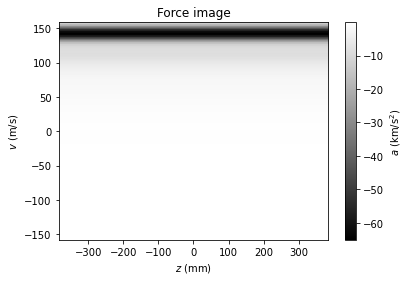

In [36]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
           extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                   (np.amin(vv*v0)), (np.amax(vv*v0))),
           aspect='auto',cmap='gray')
cb1 = plt.colorbar()
cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

# # fig.savefig('./White light/'+figname+' Force_image.png')

In [10]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=4):
    if abs(y[-1])<100:
        val = 0.
    else:
        val = 1.

    return val
def lost_condition(t,y):
    if y[-4]>4 and y[-1]>0:
        val = -1
    elif y[-4]<0:
        val = -1
    else:
        val = 1
    return val

def for_transverse_condition(t,y):
    if y[-1]>0 and y[-4]<4 and y[-4]>0:
        val = -1.
    else:
        val = 1.
    return val

captured_condition.terminal=False
lost_condition.terminal=False
for_transverse_condition.terminal = False
conditions =  [captured_condition,lost_condition,for_transverse_condition]

sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='Radau')
    sols_rate.append(rateeq.sol)

Completed in 1.20 s.                                               
Completed in 0.88 s.                                               
Completed in 1.70 s.                                               
Completed in 1.55 s.                                               
Completed in 2.65 s.                                                
Completed in 2.47 s.                                                
Completed in 3.06 s.                                                
Completed in 3.26 s.                                                
Completed in 3.89 s.                                                
Completed in 3.13 s.                                                
Completed in 3.32 s.                                                
Completed in 3.85 s.                                                
Completed in 3.87 s.                                                
Completed in 4.50 s.                                                
Completed in 5.42 s.                  

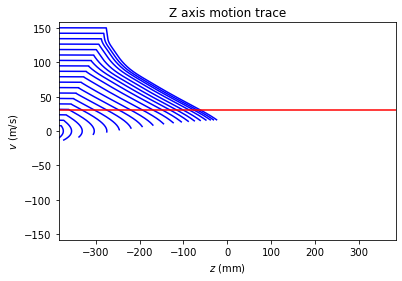

In [11]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 1)
# plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Z axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2]*x0*1000,sol.v[2]*v0, 'b')
ax.plot(zz,np.ones(len(zz))*30,'r')

# fig.savefig('./White light/'+figname+f', from {v_eval[0]} to {v_eval[-1]}'+' Motion-trace with step fucntion.png') 
# fig.savefig('./White light/'+figname+' Sine Motion-trace.png')
# fig.savefig('./PR/white motion trace.png')

In [12]:
sols_rate[10].t

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 8.01013e+05,
       8.01014e+05, 8.01015e+05])

In [13]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera

In [14]:
# fig, ax = plt.subplots(1, 1)
# camera = Camera(fig)

In [15]:
# time_steps = np.linspace(0,1000000,101)

# for time_step in tqdm(time_steps):
#     laserBeams = Fixed_detune_MgF_MOT_force(time_step,main_detune,white_detune,power_rate_1,power_rate_2,laser_on,laser_off)
#     rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)
#     rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=0)
#     ax.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
#                extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                        (np.amin(vv*v0)), (np.amax(vv*v0))),
#                aspect='auto',cmap='gray')
#     ts = int(time_step)
#     for sol in sols_rate:
#         ax.plot(sol.r[2][ts]*x0*1000,sol.v[2][ts]*v0,'go')
#     ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
#     ax.set_ylim(-1*max(v_eval)*v0,max(v_eval)*v0)
#     fig.subplots_adjust(left=0.12,right=0.9)
#     ax.set_xlabel('$z\ (\mathrm{mm})$')
#     ax.set_ylabel('$v\ (\mathrm{m/s})$')
#     ax.set_title('Force image')
#     fig.subplots_adjust(left=0.12,right=0.9)
#     camera.snap()
# xss = np.linspace(-400,400,801)
# yss = np.ones(801)*4*v0
# ax.plot(xss,yss,'r')


In [16]:
# ax.set_title('Force image & Motion trace')

In [17]:
# animation = camera.animate(interval=50, blit=False)

# from IPython.display import HTML
# HTML(animation.to_jshtml())

In [18]:
# animation.save('./PR/White light case.gif',dpi=100,writer='imagemagick')

In [19]:
from scipy import stats

In [20]:
rv = stats.norm(140,17)

In [21]:
length = np.linspace(80,200,281)

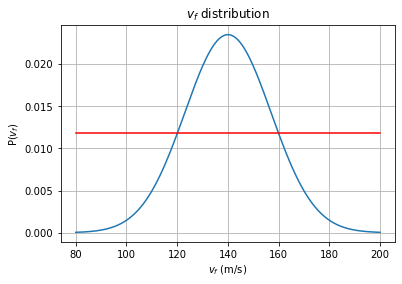

In [22]:
fig, ax = plt.subplots(1,1)

ax.plot(length,rv.pdf(length))
ax.plot(length,rv.pdf(140+17*1.175)*np.ones(281),'r')
ax.set_title('$v_f$ distribution')
ax.set_xlabel('$v_f$ ($\mathrm{m/s}$)')
ax.set_ylabel('P($v_f$)')
ax.grid()
# fig.savefig('./PR/forward distribution.png')

In [23]:
qr = stats.norm(0,18.7564)

In [24]:
length2 = np.linspace(-2*18.7564,2*18.7564,281)

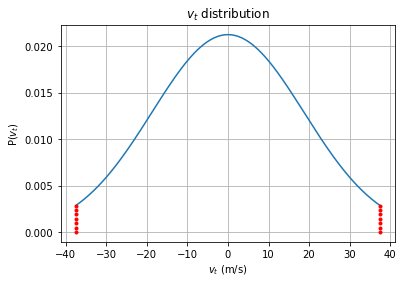

In [25]:
fig, ax = plt.subplots(1,1)

ax.plot(length2,qr.pdf(length2))
ax.plot(-2*18.7564*np.ones(7),np.linspace(0,qr.pdf(-2*18.7564),7),'r.')
ax.plot(2*18.7564*np.ones(7),np.linspace(0,qr.pdf(2*18.7564),7),'r.')
ax.set_title('$v_t$ distribution')
ax.set_xlabel('$v_t$ ($\mathrm{m/s}$)')
ax.set_ylabel('P($v_t$)')
ax.grid()
# fig.savefig('./PR/transverse distribution.png')

In [26]:
1e-3/t0

138230.07675795088